В этом блокноте попробуем использовать board2vec для обучения моделей классического машинного обучения

Для начала напишем функцию обработки данных (конкретной партии)

In [1]:
import pandas as pd

data = pd.read_csv('C:/Users/matvey/workspace/heuristic_extractor/labeled.csv')
data.head()

,id,white_elo,black_elo,moves,marks
0,787zsVup,1638.0,1851.0,e2e4 c7c6 f2f4 d7d5 e4d5 c6d5 g1f3 b8c6 d2d3 g...,"47,53"
1,F8M8OS71,1760.0,1823.0,e2e4 c7c5 g1f3 d7d6 c2c3 g8f6 d2d3 a7a6 b1d2 e...,"52,56"
2,MQSyb3KW,1877.0,1909.0,e2e4 c7c5 c2c3 d7d6 d2d4 c5d4 c3d4 b7b6 b1c3 c...,"126,130"
3,4MWQCxQ6,1741.0,1625.0,e2e4 e7e5 d2d3 b8c6 g1f3 f8c5 f1e2 g8f6 e1g1 e...,"31,35"
4,e9AY2m5j,1766.0,1733.0,e2e4 c7c5 f1c4 e7e6 g1f3 d7d5 e4d5 e6d5 c4b5 b...,"49,55"


In [2]:
import chess
import numpy as np
import pandas as pd
from typing import Union

def prepare_data(data: Union[pd.DataFrame, dict, pd.Series], board2vec) -> tuple:
    """
    Обрабатывает данные для модели, принимая как DataFrame, так и отдельные записи.

    Args:
        data: Входные данные - DataFrame или отдельная запись (dict/Series)
        board2vec: Функция кодирования досок

    Returns:
        Кортеж (признаки, целевая_переменная)
    """
    # Преобразуем одиночные записи в DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame([data] if not isinstance(data, list) else data)

    dfs = []
    for row in data.itertuples(index=False):
        # Извлекаем параметры из строки
        start, end = map(int, row.marks.split(','))
        board = chess.Board()
        boards = []
        target = []

        # Генерируем последовательность досок и целевых значений
        for i, move in enumerate(row.moves.split()):
            board.push(chess.Move.from_uci(move))
            boards.append(board.copy())
            target.append(int(start <= i < end))

        # Кодируем доски и формируем DataFrame
        encoded = board2vec(boards)
        df = pd.DataFrame(np.vstack(encoded))
        df['white_elo'] = row.white_elo
        df['black_elo'] = row.black_elo
        df['target'] = target

        dfs.append(df)

    # Объединяем все данные
    result = pd.concat(dfs, ignore_index=True)
    result.columns = result.columns.astype(str)

    return result.drop(columns='target'), result['target']

In [3]:
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

def validate(y_pred, y_true):
    # Оцениваем качество модели
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Выводим метрики качества
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)


def make_lgb(X, y):
    train_data = lgb.Dataset(X, label=y)
    # Параметры модели
    params = {
        'objective': 'binary',  # Для бинарной классификации
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 40,
        'learning_rate': 0.01
    }

    return lgb.train(params, train_data, num_boost_round=500)

Начнём с первой модели для получения эмбеддингов: полносвязнный перцептрон

In [4]:
from experiments.experiment_01.inference import board2vec as board2vec01
embed_func = board2vec01
X_train_01, y_train_01 = prepare_data(data.sample(1500, random_state=42), embed_func)
X_test_01, y_test_01 = prepare_data(data.sample(500, random_state=52), embed_func)
print(X_train_01.shape, X_test_01.shape)

(92670, 66) (31880, 66)


In [5]:
model_1 = make_lgb(X_train_01, y_train_01)
validate(model_1.predict(X_test_01) > 0.5, y_test_01)

[LightGBM] [Info] Number of positive: 6902, number of negative: 85768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16829
[LightGBM] [Info] Number of data points in the train set: 92670, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074479 -> initscore=-2.519835
[LightGBM] [Info] Start training from score -2.519835
Accuracy: 0.9263
Precision: 0.4231
Recall: 0.0047
F1 Score: 0.0093
Confusion Matrix:
[[29521    15]
 [ 2333    11]]


На очереди вторая модель: свёрточная нейросеть с двумя residual блоками

In [6]:
from experiments.experiment_02.inference import board2vec as board2vec02
embed_func = board2vec02
X_train_02, y_train_02 = prepare_data(data.sample(1500, random_state=42), embed_func)
X_test_02, y_test_02 = prepare_data(data.sample(500, random_state=52), embed_func)

device: cpu


In [7]:
model_2 = make_lgb(X_train_02, y_train_02)
validate(model_2.predict(X_test_02) > 0.5, y_test_02)

[LightGBM] [Info] Number of positive: 6902, number of negative: 85768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16829
[LightGBM] [Info] Number of data points in the train set: 92670, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074479 -> initscore=-2.519835
[LightGBM] [Info] Start training from score -2.519835
Accuracy: 0.9260
Precision: 0.4273
Recall: 0.0201
F1 Score: 0.0383
Confusion Matrix:
[[29473    63]
 [ 2297    47]]


Далее третья модель: свёрточная нейросеть с одним residual блоком и модифицированным процессом обучения

In [8]:
from experiments.experiment_03.inference import board2vec as board2vec03
embed_func = board2vec03
X_train_03, y_train_03 = prepare_data(data.sample(1500, random_state=42), embed_func)
X_test_03, y_test_03 = prepare_data(data.sample(500, random_state=52), embed_func)

device: cpu


In [9]:
model_3 = make_lgb(X_train_03, y_train_03)
validate(model_3.predict(X_test_03) > 0.5, y_test_03)

[LightGBM] [Info] Number of positive: 6902, number of negative: 85768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16829
[LightGBM] [Info] Number of data points in the train set: 92670, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074479 -> initscore=-2.519835
[LightGBM] [Info] Start training from score -2.519835
Accuracy: 0.9267
Precision: 0.5327
Recall: 0.0243
F1 Score: 0.0465
Confusion Matrix:
[[29486    50]
 [ 2287    57]]


Чиселки это хорошо, но давайте посмотрим, как именно модель справляется на конкретных данных

0.1594795055455139 0.06298551004259571


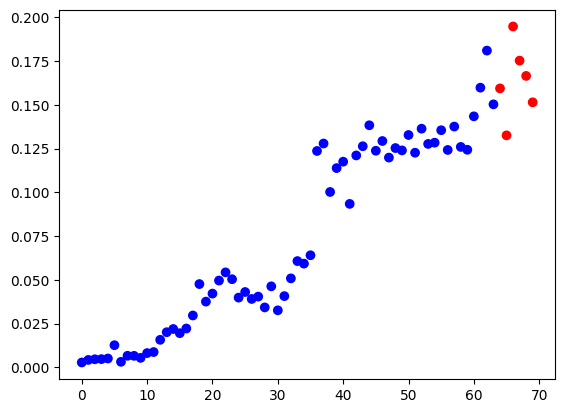

In [10]:
import matplotlib.pyplot as plt

X, y = prepare_data(data.sample(1), board2vec01)
y_pred = model_1.predict(X)
t = np.percentile(y_pred, 100 - 7)
m = y_pred.mean() * 1.2
print(t, t - m)
plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, c=y, cmap='bwr')
plt.show()

Если на предсказанные вероятности просто поставить некоторый порог, выход модели получится не таким, как хотелось бы. Попробую описать интуицию, которая поможет нам улучшить выхлоп модели:

1. Если некоторая позиция предсказана как интересная, то позиции слева и справа от неё вероятно тоже интересны, даже если модель уверена в этом меньше, чем в данной позиции
2. Если два интересных момента находятся очень близко, их в целом можно объединить в один интересный момент
3. Интересные моменты обычно длятся 3-4 полухода. Значит очень короткие предсказания можно отсечь

Напишем алгоритм, который учитывает эту интуицию и улучшает выход модели

In [15]:
def pseudo_inference(model: lgb.Booster, sample: pd.DataFrame, embedding_function, alpha: float, show = False):
    X, y_true = prepare_data(sample, embedding_function)
    y_pred = model.predict(X)
    t = max(0.10, np.percentile(y_pred, 100 - 5))
    m = np.mean(y_pred)
    y_result = y_pred > t

    window_size = 2
    eps = alpha * t + (1 - alpha) * m
    for i in np.where(y_pred > t)[0]:
        y_result[i - window_size:i + window_size + 1] = y_pred[i - window_size:i + window_size + 1] > eps

    # for i in range(1, len(y_result) - 1):
    #     if y_result[i - 1] and y_result[i + 1]:
    #         y_result[i] = 1

    result = []
    flag = False
    start = -1
    for i in range(len(y_result)):
        if y_result[i] and not flag:
            start = i
            flag = True
        if not y_result[i] and flag:
            flag = False
            if i - start < 4:
                for j in range(start, i):
                    y_result[j] = 0
            else:
                result.append((start, i))
    if flag:
        result.append((start, len(y_result)))
    if show:
        plt.scatter(x=np.arange(y_pred.shape[0]), y=y_result, c=y_true, cmap='bwr')
        plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, alpha=0.8, c='k')
        plt.show()
    return y_result, y_true, result

In [16]:
# for _ in range(3):
#     pseudo_inference(model_3, data.sample(1), board2vec03, show=True)

def validate(inference_func):
    precisions = []
    recalls = []
    for _ in range(350):
        y_pred, y_true, _ = inference_func(data.sample(1))
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred))
    return sum(precisions) / len(precisions), sum(recalls) / len(recalls)

for alpha in np.linspace(0.01, 0.99, num=15):
    precision, recall = validate(lambda x: pseudo_inference(model_3, x, board2vec03, alpha=alpha))
    print(f'alpha={alpha}, precision={precision}, recall={recall}, f1_score={2 * precision * recall / (precision + recall)}')

alpha=0.01, precision=0.3780890398068195, recall=0.600547619047619, f1_score=0.46403426765103156
alpha=0.07999999999999999, precision=0.4275133067335636, recall=0.6446428571428571, f1_score=0.5140918996779291
alpha=0.15, precision=0.4194648799649908, recall=0.617408163265306, f1_score=0.4995424324788151
alpha=0.21999999999999997, precision=0.407464517029975, recall=0.5722142857142857, f1_score=0.47598665381573596
alpha=0.29, precision=0.45262648773911096, recall=0.5807959183673469, f1_score=0.508763144809815
alpha=0.36, precision=0.43633471118050987, recall=0.5514115646258502, f1_score=0.48716965416284935
alpha=0.42999999999999994, precision=0.4304757327173297, recall=0.53412987012987, f1_score=0.47673359253085423
alpha=0.49999999999999994, precision=0.4706573664430811, recall=0.5065884353741497, f1_score=0.48796234973913044
alpha=0.57, precision=0.4472308964145098, recall=0.48723809523809525, f1_score=0.46637808647938606
alpha=0.6399999999999999, precision=0.46476048321426494, recall=

Партия №1


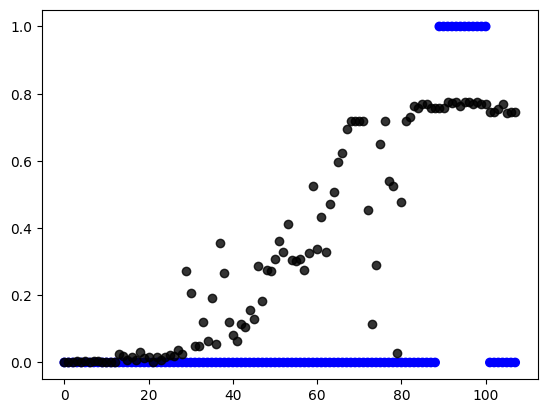

Интересные моменты: ['45B-51B']
Партия №2


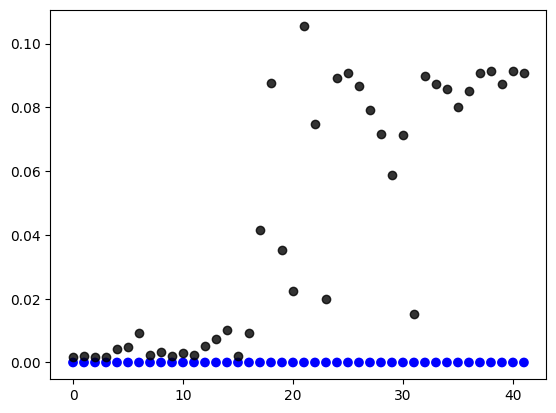

Интересные моменты: []
Партия №3


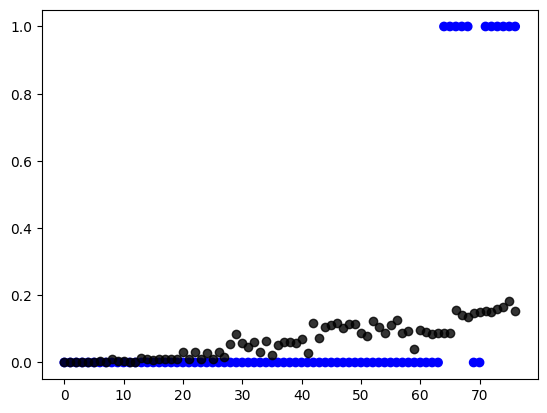

Интересные моменты: ['33W-35B', '36B-39B']
Партия №4


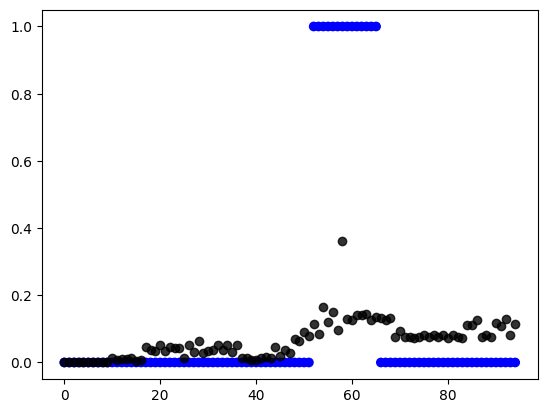

Интересные моменты: ['27W-34W']
Партия №5


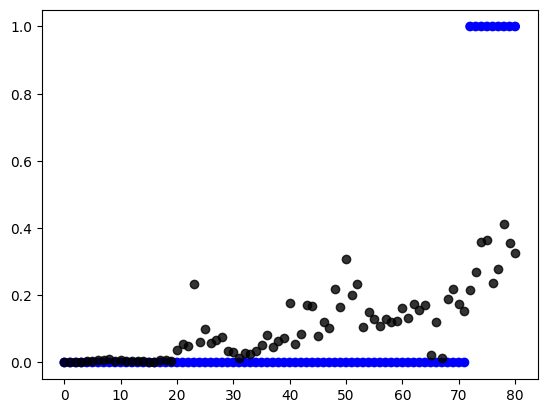

Интересные моменты: ['37W-41B']
Партия №6


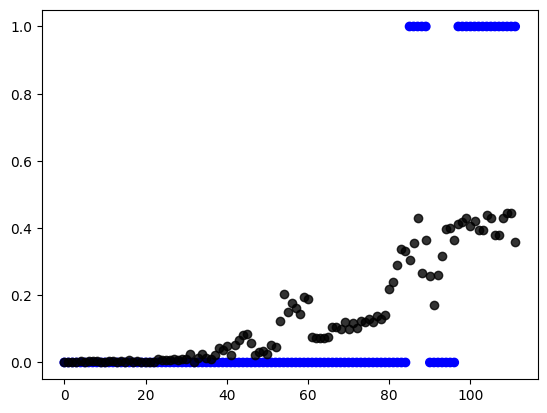

Интересные моменты: ['43B-46W', '49B-57W']
Партия №7


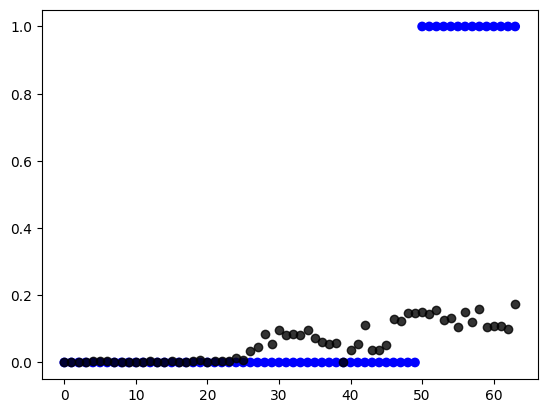

Интересные моменты: ['26W-33W']
Партия №8


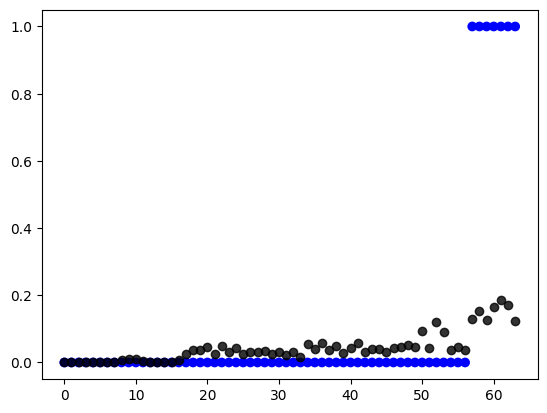

Интересные моменты: ['29B-33W']
Партия №9


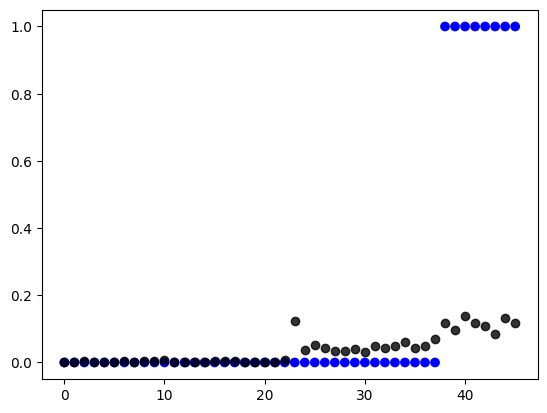

Интересные моменты: ['20W-24W']
Партия №10


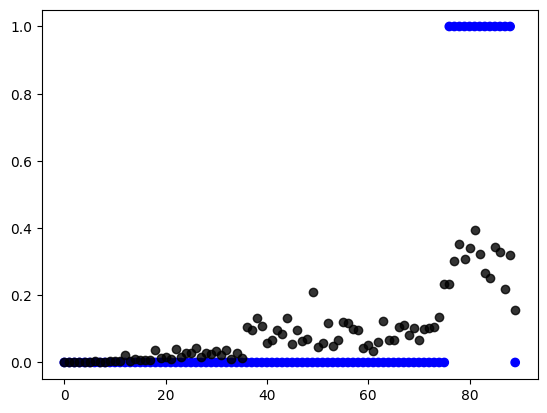

Интересные моменты: ['39W-45B']


In [17]:
validate_data = pd.read_csv('C:/Users/matvey/workspace/heuristic_extractor/example.csv')
for i in range(validate_data.shape[0]):
    print(f'Партия №{i + 1}')
    moves = validate_data.iloc[i]
    y_pred, y_true, result = pseudo_inference(model_3, moves, board2vec03, alpha=0.08, show=True)
    func = lambda num: f"{num // 2 + 1}{'W' if num % 2 == 0 else 'B'}"
    print('Интересные моменты:', [f"{func(start)}-{func(end)}" for start, end in result])